## 2.1. 데이터 로드
- 학습 데이터셋: train.pkl.gz
- 평가 데이터셋: test.pkl.gz

In [108]:
import numpy as np
import pandas as pd

train_df = pd.read_pickle("./train.pkl.gz")
test_df = pd.read_pickle("./test.pkl.gz")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1493893 entries, 0 to 1493892
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   index   1493893 non-null  object        
 1   dt      1493893 non-null  datetime64[ns]
 2   cnt     1493893 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 34.2+ MB


## 2.3. 데이터 전처리

Tensor의 구성은 [day, timestep, count] 로 구성할 예정입니다.  
즉 날자를 batch로 삼고자 합니다.

또한 저는 시간별로 모든 지역의 cnt를 합쳐줄 것 입니다.  
그럼에도 만약 공백 시간대가 발생한다면 0으로 채워줄 것 입니다.

In [292]:
train = train_df.copy()
train[train['dt'].dt.day == 1]

,index,dt,cnt
0,ce6028f30ca4be4b58e0453b633469ed27fb8c9f,2021-05-01 00:00:00,2
1,ce6028f30ca4be4b58e0453b633469ed27fb8c9f,2021-05-01 19:00:00,1
2,ce6028f30ca4be4b58e0453b633469ed27fb8c9f,2021-05-01 19:10:00,2
3,ce6028f30ca4be4b58e0453b633469ed27fb8c9f,2021-05-01 19:20:00,2
4,ce6028f30ca4be4b58e0453b633469ed27fb8c9f,2021-05-01 19:30:00,0
...,...,...,...
1493216,1383c8d21ddf42b2f93dc7e3f3d2b9a80c3aa617,2021-05-01 23:10:00,6
1493217,1383c8d21ddf42b2f93dc7e3f3d2b9a80c3aa617,2021-05-01 23:20:00,6
1493218,1383c8d21ddf42b2f93dc7e3f3d2b9a80c3aa617,2021-05-01 23:30:00,4
1493219,1383c8d21ddf42b2f93dc7e3f3d2b9a80c3aa617,2021-05-01 23:40:00,6


In [293]:
train = train_df.copy()
train['dt'] = train['dt'].map(lambda x: x.strftime('%d %H:%M'))
a = []
for day in range(1, 28):
    for hour in range(0, 24):
        for mi in range(0, 60, 10):
            day = str(day).zfill(2)
            hour = str(hour).zfill(2)
            mi = str(mi).zfill(2)
            time = day + ' ' + hour + ':' + mi
            a.append([time, train[train['dt'] == time]['cnt'].sum()])
            
train = pd.DataFrame(a, columns=['dt', 'cnt'])

In [294]:
train

,dt,cnt
0,01 00:00,17448
1,01 00:10,15503
2,01 00:20,13970
3,01 00:30,12474
4,01 00:40,11289
...,...,...
3883,27 23:10,20973
3884,27 23:20,15663
3885,27 23:30,12772
3886,27 23:40,11446


지금부터는 학습을 위해 Pytorch Tensor로 바꿔줄 예정입니다.

In [295]:
!pip install -U pytorch
import torch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch: started
    Running setup.py install for pytorch: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'D:\anaconda3\envs\PROJECT\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\tolight20\\AppData\\Local\\Temp\\pip-install-_3xw_zr_\\pytorch_0177a7d5562d4063b332b6c05dcbe804\\setup.py'"'"'; __file__='"'"'C:\\Users\\tolight20\\AppData\\Local\\Temp\\pip-install-_3xw_zr_\\pytorch_0177a7d5562d4063b332b6c05dcbe804\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\tolight20\AppData\Local\Temp\pip-wheel-lbiskqqo'
       cwd: C:\Users\tolight20\AppData\Local\Temp\pip-install-_3xw_zr_\pytorch_0177a7d5562d4063b332b6c05dcbe804\
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\tolight20\AppData\Local\Temp\pip-install-_3xw_zr_\pytorch_0177a7d5562d4063b332b6c05dcbe804\setup.py", line 

toDataset함수로 input array와 output array를 생성해 줄 예정입니다.  
input array로는 현재 시점 (t0)와 이전 6개 시점 (t-6 ~ t-1)인 총 7개 시점이 될 것이며  
output array는 바로 다음 시점을 예측하면서 학습을 진행할 예정입니다.

In [326]:
def toDataset(df, window = 7):
    feature_list = []
    label_list = []
    for i in range(len(df)-window):
        feature_list.append(np.array(df.iloc[i:i+window]))
        label_list.append(np.array(df.iloc[i+window]))
        
    return np.array(feature_list), np.array(label_list)

In [327]:
X, Y = toDataset(train[train['dt'].str.contains('01 ')]['cnt'])
X = torch.from_numpy(X).float().view(1, -1, 7)
Y = torch.from_numpy(Y).float().view(1, -1, 1)

for i in range(2, 28):
    day = str(i).zfill(2) + ' '
    temp_x, temp_y = toDataset(train[train['dt'].str.contains(day)]['cnt'])
    temp_x = torch.from_numpy(temp_x).float().view(1, -1, 7)
    temp_y = torch.from_numpy(temp_y).float().view(1, -1, 1)
    X = torch.cat((X, temp_x), 0)
    Y = torch.cat((Y, temp_y), 0)

In [328]:
Y.shape

torch.Size([27, 137, 1])

## 2.4. 모델링

In [330]:
import torch.nn as nn

class LSTM_(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        
        
        self.lstm =nn.LSTM(input_dim, hidden_dim, num_layers, batch_first =True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        
        out,(hn, cn)=self.lstm(x, (h0,c0))
        
        
        out = self.fc(out)
        
        return out
    
    def init_hidden(self,x):
        self.h0 =torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        self.c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        
        return self.h0, self.c0

Epoch  10 MSE:  145481040.0
Epoch  20 MSE:  145276416.0
Epoch  30 MSE:  145070496.0
Epoch  40 MSE:  144865920.0
Epoch  50 MSE:  144663120.0
Epoch  60 MSE:  144462128.0
Epoch  70 MSE:  144262912.0
Epoch  80 MSE:  144065360.0
Epoch  90 MSE:  143869440.0
Epoch  100 MSE:  143675056.0
Epoch  110 MSE:  143491040.0
Epoch  120 MSE:  143300496.0
Epoch  130 MSE:  143111120.0
Epoch  140 MSE:  142923168.0
Epoch  150 MSE:  142736384.0
Epoch  160 MSE:  142551216.0
Epoch  170 MSE:  142367008.0
Epoch  180 MSE:  142184256.0
Epoch  190 MSE:  142002368.0
Epoch  200 MSE:  141821312.0
Epoch  210 MSE:  141641888.0
Epoch  220 MSE:  141463776.0
Epoch  230 MSE:  141286880.0
Epoch  240 MSE:  141111040.0
Epoch  250 MSE:  140936464.0
Epoch  260 MSE:  140778832.0
Epoch  270 MSE:  140607056.0
Epoch  280 MSE:  140436736.0
Epoch  290 MSE:  140267296.0
Epoch  300 MSE:  140098896.0
Epoch  310 MSE:  139931664.0
Epoch  320 MSE:  139765536.0
Epoch  330 MSE:  139626432.0
Epoch  340 MSE:  139463088.0
Epoch  350 MSE:  139300

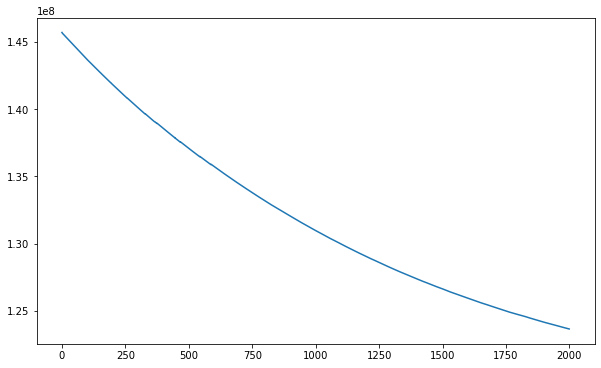

In [331]:
model = LSTM_(input_dim=7,hidden_dim=512,output_dim=1,num_layers=1)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 2000

hist = np.zeros(epochs)    
    
for t in range(epochs):    
    
    # Forward
    y_pred = model(X)

    loss = loss_fn(y_pred, Y)
    if t % 100 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    
    # Backward
    loss.backward()
    optimiser.step()
    
plt.figure(figsize=(10, 6))
plt.plot(hist, label='loss')

## 2.5. 평가

주어진 베이스라인 모델의 성능을 뛰어넘으면서, 좋은 성능을 보이는지 평가합니다.
- 테스트 데이터셋에 대한 베이스라인 모델의 성능: MSE 기준 약 250, MAE 기준 약 3.5

사용할 테스트 test dataset은 가장 데이터 양이 많은 index에서 선택하겠습니다.  
연속된 13개의 시점을 선택하고 첫 7개 시점을 input, 마지막 6개 시점을 score측정을 위한 validation 시점으로 활용할 생각입니다.

임의로 2021년 05월 31일 20:00:00 부터 22:00:00까지 13개의 시점을 선택해 test해보도록 하겠습니다.

In [372]:
X_test = test_df[test_df['index'] == 'b0ad34010d3f9eb1830e9e8c8ba45a8381d8f59b']
X_test = X_test.loc[168689:168701].drop(['index', 'dt'], axis=1)
Y_test = X_test[-6:]
X_test = X_test[0:7]
X_test = torch.from_numpy(np.array(X_test)).float().view(1, -1, 7)
Y_test = torch.from_numpy(np.array(Y_test)).float().view(1, -1, 1)

In [374]:
Y_test.shape

torch.Size([1, 6, 1])

In [380]:
loss_mse = torch.nn.MSELoss()
loss_mae = torch.nn.L1Loss()
with torch.no_grad():
    for i in range(6):
        Y_pred = model(X_test[:,:,i:i+7])
        X_test = torch.cat((X_test, Y_pred), 2)
    Y_preds = X_test[:,:,-6:]
    mse_loss = loss_mse(Y_preds.view(-1), Y_test.view(-1))
    mae_loss = loss_mae(Y_preds.view(-1), Y_test.view(-1))
    print(f'MSE Loss is {mse_loss}, MAE Loss is {mae_loss}')

MSE Loss is 4608869.5, MAE Loss is 2142.115234375
